# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import sys
import os

import torch
from torch import nn
from torch.utils import data

sys.path.append("../../src")
sys.path.append("../palm-tree")

from collections import Counter

import embedder
import models
import utils
import dataset

In [2]:
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(42)

In [3]:
torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#torch.device('cpu')

device(type='cuda', index=1)

# Imdb Sentiment Dataset

In [4]:
data_df = pd.read_pickle("../../dataset/bb_data/good_dataset.pkl").drop(columns = ["bb_embeddings"])

We clean instructions of large constants based on paper explanation. We also remove commas

In [5]:
def remove_addresses(bb: list[str]) -> list[str]:

    clean_bb = []
    for inst in bb:
        inst_list = inst.split()
        clean_inst = [tok.replace(",", "") for tok in inst_list if len(tok) < 8]
        clean_bb.append(" ".join(clean_inst))

    return clean_bb

In [6]:
data_df.bb = data_df.bb.map(remove_addresses)

We create the vocab and tokenize the data

In [73]:
counts = Counter(inst for bb in data_df.bb.tolist() for inst in set(bb))

vocab = {inst: i for i, (inst, _) in enumerate(counts.most_common(20000), start=1)}
vocab["UNK"] = 0
vocab["PAD"] = vocab[max(vocab, key=vocab.get)] + 1

In [74]:
print(f"size of vocabulary: {len(vocab)}")

size of vocabulary: 1610


We remove outliers in order to have more balanced padded sequences

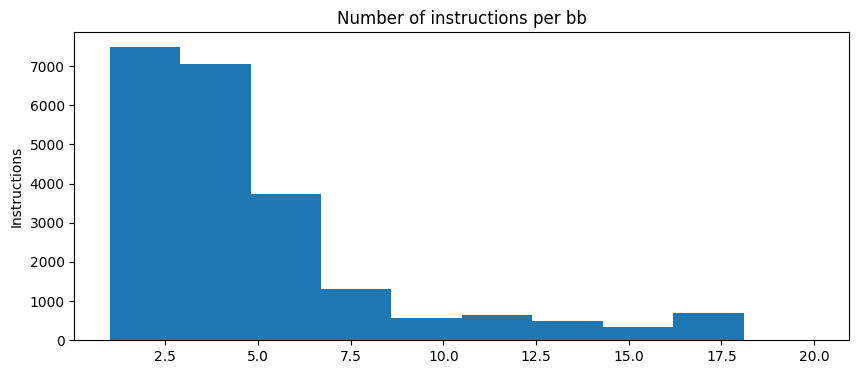

In [75]:
plt.figure(figsize=(10,4))
plt.hist(data_df.bb.map(len))
plt.title("Number of instructions per bb")
plt.ylabel("Instructions")
plt.show()

In [76]:
MAX_INSTS = 10
MAX_WORDS = 3

def encode_bb(bb: list[str], vocab: dict) -> list:

    encoded_bb = []    
    for inst in bb[:MAX_INSTS]:
    
        if inst in vocab.keys():
            encoded_bb.append(vocab[inst])
        else:
            encoded_bb.append(vocab["UNK"])
        
    if len(encoded_bb) < MAX_INSTS:
        encoded_bb.extend([vocab["PAD"] for i in range(len(encoded_bb), MAX_INSTS)])
 
    return encoded_bb

In [77]:
data_df["encoded_bb"] = data_df.bb.apply(lambda x: encode_bb(x, vocab))

In [78]:
data_df.head(10)

,bb,energy,encoded_bb
0,"[mov %rbx %r15, movl %r9d, mov %r8 %rsi, mov %...",2.913363,"[290, 16, 292, 38, 291, 120, 6, 4, 37, 36]"
1,"[movzx %bl %eax, popq %rbx, popq %rbp, popq %r...",0.359342,"[183, 7, 8, 9, 5, 1609, 1609, 1609, 1609, 1609]"
2,"[movq %r10, lea %rsi, movq %r11, mov %rbx %rdi...",0.490156,"[436, 166, 236, 164, 64, 23, 704, 742, 741, 1609]"
3,"[cmp $0x20 %rdx, jb 0x4b]",0.297282,"[112, 113, 1609, 1609, 1609, 1609, 1609, 1609,..."
4,"[callq 0x5d2bd, nop %edi %edx, mov %rax, movq ...",0.899731,"[959, 4, 66, 45, 960, 1609, 1609, 1609, 1609, ..."
5,[retq],0.237825,"[5, 1609, 1609, 1609, 1609, 1609, 1609, 1609, ..."
6,"[test %rbp %rbp, jz 0x7c]",0.163337,"[174, 179, 1609, 1609, 1609, 1609, 1609, 1609,..."
7,"[cmp $0x1f %rbx, jbe 0x2a4]",0.246546,"[504, 503, 1609, 1609, 1609, 1609, 1609, 1609,..."
8,"[cmp %rax %r15, jnz 0x285]",0.297282,"[62, 364, 1609, 1609, 1609, 1609, 1609, 1609, ..."
9,"[movq %rax, mov %rax %rdx, sub %rdx, cmpq %rdx...",0.591711,"[2, 42, 148, 73, 293, 1609, 1609, 1609, 1609, ..."


# Torch dataset preprocessing

In [79]:
class EnergyPredictionVocabDataset(data.Dataset):
    def __init__(self, data_df: pd.DataFrame, mean: bool = False):
        super().__init__()
    
        x = np.array(data_df.encoded_bb.tolist())
        y = data_df.energy.values
        self.x_train = list(map(lambda x: torch.tensor(x), x))
        self.y_train = list(map(lambda y: torch.tensor(y), y))

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx: int):
        return self.x_train[idx], self.y_train[idx]

In [80]:
split = 0.9

data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)

bb_df_train = data_df[:int(split * len(data_df))]
bb_df_val = data_df[int(split * len(data_df)):]

In [81]:
BATCH_SIZE = 32

train_data = EnergyPredictionVocabDataset(bb_df_train)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

val_data = EnergyPredictionVocabDataset(bb_df_val)
val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Model

In [86]:
class LSTM_Classifier(nn.Module):

    def __init__(self, vocab_size: int, hidden_size: int = 16, num_layers: int = 2, bidirectional: bool = False) -> None:
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, 128)

        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0.1,
        )

        self.dense = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(0.1)
        self.smaller_dense = nn.Linear(128, 16)
        self.regressor = nn.Linear(16, 1)

    def forward(self, x, hidden):
        
        batch_size = x.size(0)
        
        embeddings = self.embedding(x)
        
        lstm_out, hidden_state = self.lstm(embeddings, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        out = self.dense(lstm_out)
        out = self.dropout(out)
        out = self.smaller_dense(out)
        out = self.regressor(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden_state

    def init_hidden(self, batch_size):
        
        hidden = (torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
                  torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda())
        
        return hidden

In [89]:
VECTOR_DIM = len(vocab)
NUM_LAYERS = 10
HIDDEN_DIM = 256

model = LSTM_Classifier(vocab_size=VECTOR_DIM, hidden_size=HIDDEN_DIM, num_layers=NUM_LAYERS)
print(model)

LSTM_Classifier(
  (embedding): Embedding(1610, 128)
  (lstm): LSTM(128, 256, num_layers=10, batch_first=True, dropout=0.1)
  (dense): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (smaller_dense): Linear(in_features=128, out_features=16, bias=True)
  (regressor): Linear(in_features=16, out_features=1, bias=True)
)


# Training

In [90]:
EPOCHS = 100

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-4)

model.cuda()
model.train()

cnt = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    hidden_state = model.init_hidden(batch_size=BATCH_SIZE)
    losses = []
    for embeddings, labels in train_loader:

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        hidden_state = tuple([each.data for each in hidden_state])


        output, hidden_state = model(embeddings, hidden_state)
        loss = criterion(output.squeeze(), labels.float())

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.item())

    val_h = model.init_hidden(BATCH_SIZE)
    val_loss = []
    model.eval()
    for embeddings, labels in val_loader:

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history

        embeddings, labels = embeddings.cuda(), labels.cuda()  
        output, val_h = model(embeddings, val_h)
        v_loss = criterion(output.squeeze(), labels.float())

        val_loss.append(v_loss.item())

    model.train()
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, MSE Train Loss: {round(np.mean(losses), 5)}, MSE Val Loss: {round(np.mean(val_loss), 5)}"
    )

    train_losses.append(np.mean(losses))
    val_losses.append(np.mean(val_loss))

Epoch: 1/100, MSE Train Loss: 1.03961, MSE Val Loss: 0.84792
Epoch: 2/100, MSE Train Loss: 0.87208, MSE Val Loss: 0.8468
Epoch: 3/100, MSE Train Loss: 0.87144, MSE Val Loss: 0.8468
Epoch: 4/100, MSE Train Loss: 0.87111, MSE Val Loss: 0.8468
Epoch: 5/100, MSE Train Loss: 0.87091, MSE Val Loss: 0.84683
Epoch: 6/100, MSE Train Loss: 0.90386, MSE Val Loss: 0.84725
Epoch: 7/100, MSE Train Loss: 0.87128, MSE Val Loss: 0.8469
Epoch: 8/100, MSE Train Loss: 0.87053, MSE Val Loss: 0.8469


KeyboardInterrupt: 

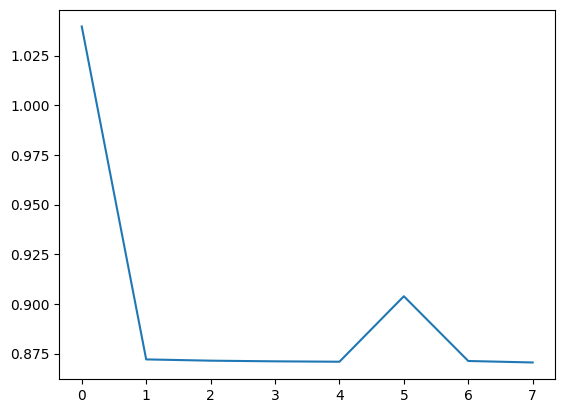

In [91]:
plt.plot(train_losses)
plt.show()

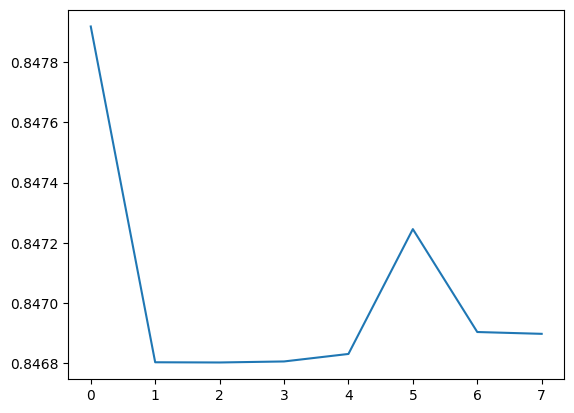

In [92]:
plt.plot(val_losses)
plt.show()

In [94]:
preds = []

val_h = model.init_hidden(BATCH_SIZE)
for embeddings, labels in val_loader:

    embeddings, labels = embeddings.cuda(), labels.cuda()  
    output, val_h = model(embeddings, val_h)
    preds.append(output.tolist())

preds = np.array(preds).flatten()

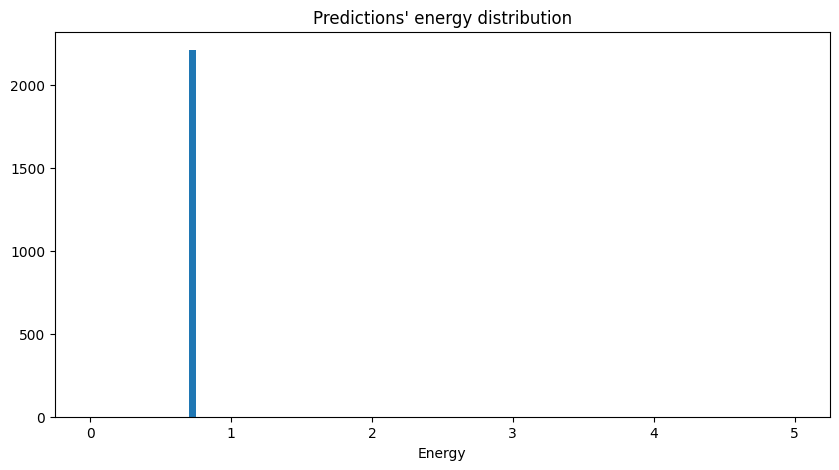

In [95]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

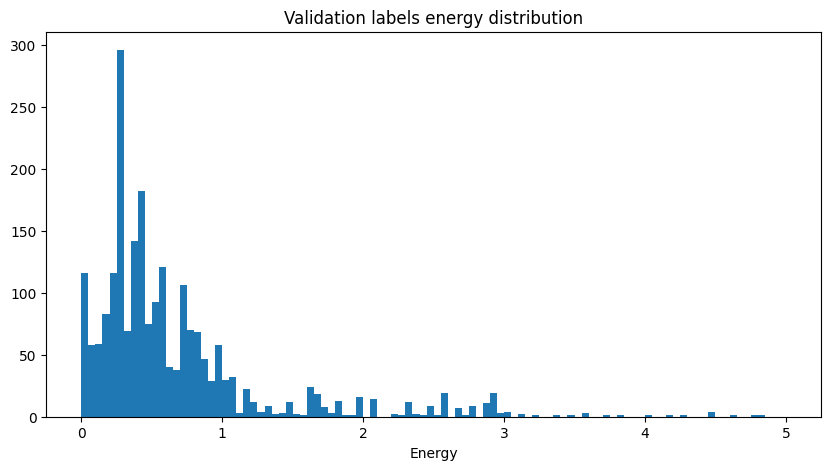

In [96]:
val_labels = bb_df_val.energy

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()